# Jointree Algorithm

## Build jointree

In [13]:
import json
import networkx as nx
import itertools
import functools
import pandas as pd

def get_data():
    with open('./huang.json', 'r') as fp:
        return json.load(fp)

def get_dag():
    d = nx.DiGraph()
    d.add_nodes_from(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'])
    d.add_edges_from([
        ('A', 'B'),
        ('A', 'C'),
        ('B', 'D'),
        ('C', 'E'),
        ('D', 'F'),
        ('E', 'F'),
        ('C', 'G'),
        ('E', 'H'),
        ('G', 'H')
    ])
    
    return d

def get_ug(d):
    return d.to_undirected()

def moralize(d, u):
    m = u.copy()
    for ch in d:
        parents = list(d.predecessors(ch))
        parents = itertools.combinations(parents, 2)
        for pa1, pa2 in parents:
            if not u.has_edge(pa1, pa2):
                m.add_edge(pa1, pa2)
    return m

def get_node_weight(node):
    return len(D['domain'][node])

def get_cluster_weight(nodes):
    if len(nodes) == 0:
        return 0
    weights = map(lambda n: get_node_weight(n), nodes)
    return functools.reduce(lambda a, b: a * b, weights)

def get_required_edges(g, node):
    nodes = list(g.neighbors(node)) + [node]
    edges = itertools.combinations(nodes, 2)
    edges = filter(lambda e: not g.has_edge(e[0], e[1]), edges)
    edges = list(edges)
    
    return edges

def get_num_required_edges(g, node):
    edges = get_required_edges(g, node)
    return len(edges)

def get_triangulation_info(g, n):
    return {
        'node': n,
        'weight': get_cluster_weight(list(g.neighbors(n))),
        'edges': get_num_required_edges(g, n)
    }

def get_all_triangulation_info(g):
    return pd.DataFrame([get_triangulation_info(g, n) for n in g.nodes()]) \
        .sort_values(['edges', 'weight'])

def get_best_triangulation(g):
    return get_all_triangulation_info(g).iloc[0]['node']

def is_subset(lhs, clusters):
    for rhs in clusters:
        if len(lhs) == len(lhs & rhs):
            return True
    return False

def init_join_tree(clusters):
    g = nx.Graph()
    for c in clusters:
        g.add_node('|'.join(sorted(list(c))), nodes=c, type='cluster')
    return g
    
def triangulate(m):
    n = m.copy()
    t = m.copy()
    clusters = []

    while len(n.nodes()) > 0:
        best_node = get_best_triangulation(n)
        best_cluster = set([best_node] + list(n.neighbors(best_node)))
        
        edges = get_required_edges(n, best_node)
        for n1, n2 in edges:
            n.add_edge(n1, n2)
            t.add_edge(n1, n2)
            
        n.remove_node(best_node)

        if not is_subset(best_cluster, clusters):
            clusters.append(best_cluster)

    return t, clusters

def create_sepsets(g):
    def get_record(X, Y):
        X_n = g.nodes[X]['nodes']
        Y_n = g.nodes[Y]['nodes']
        S_n = X_n & Y_n
        S = '|'.join(sorted(list(S_n)))
        return {
            'X': X, 'Y': Y, 'S': S,
            'X_n': X_n, 'Y_n': Y_n, 'S_n': S_n
        }
        
    S = list(g.nodes())
    S = itertools.combinations(S, 2)
    S = map(lambda tup: get_record(tup[0], tup[1]), S)
    
    return pd.DataFrame(S) \
        .assign(mass=lambda d: d['S_n'].apply(len)) \
        .assign(cost=lambda d: d.apply(lambda r: get_cluster_weight(r['X_n']) + get_cluster_weight(r['Y_n']), axis=1)) \
        .sort_values(['mass', 'cost'], ascending=[False, True]) \
        .reset_index(drop=True)
    
def get_optimal_join_tree(clusters):
    j = init_join_tree(clusters)
    S = create_sepsets(j)

    n_clusters = len(clusters)
    n_sepset_added = 0

    while n_sepset_added < n_clusters - 1:
        X = S.iloc[0]['X']
        Y = S.iloc[0]['Y']
        S_id = S.iloc[0]['S']
        S_n = S.iloc[0]['S_n']

        if not nx.has_path(j, X, Y):
            n_sepset_added += 1
            j.add_node(S_id, nodes=S_n, type='sepset')
            j.add_edge(X, S_id)
            j.add_edge(Y, S_id)

        S = S.iloc[1:]

    return j

In [14]:
D = get_data()

In [15]:
d = get_dag()

In [16]:
u = get_ug(d)

In [17]:
m = moralize(d, u)
list(m.edges())

[('A', 'B'),
 ('A', 'C'),
 ('B', 'D'),
 ('C', 'E'),
 ('C', 'G'),
 ('D', 'F'),
 ('D', 'E'),
 ('E', 'F'),
 ('E', 'H'),
 ('E', 'G'),
 ('G', 'H')]

In [18]:
t, clusters = triangulate(m)
list(t.edges())
clusters

[{'D', 'E', 'F'},
 {'E', 'G', 'H'},
 {'C', 'E', 'G'},
 {'A', 'B', 'C'},
 {'B', 'C', 'D'},
 {'C', 'D', 'E'}]

In [25]:
j = get_optimal_join_tree(clusters)

list(j.edges())

[('D|E|F', 'D|E'),
 ('E|G|H', 'E|G'),
 ('C|E|G', 'E|G'),
 ('C|E|G', 'C|E'),
 ('A|B|C', 'B|C'),
 ('B|C|D', 'B|C'),
 ('B|C|D', 'C|D'),
 ('C|D|E', 'D|E'),
 ('C|D|E', 'C|E'),
 ('C|D|E', 'C|D')]

## Visualize

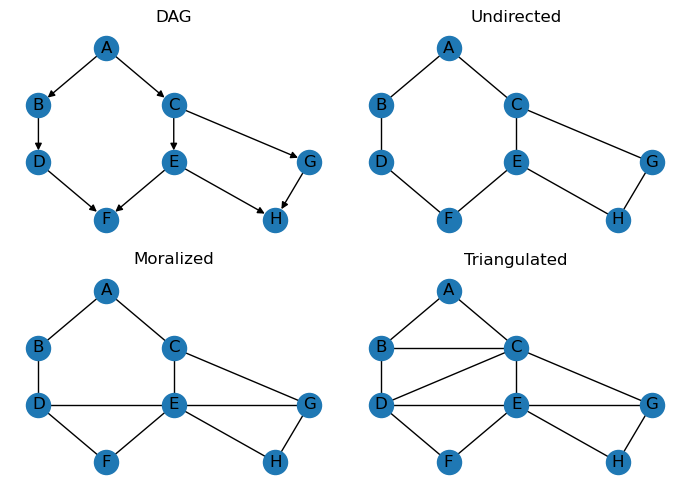

In [20]:
import matplotlib.pyplot as plt
import numpy as np

pos = nx.nx_agraph.graphviz_layout(d, prog='dot')

fig, ax = plt.subplots(2, 2, figsize=(7, 5))
ax = np.ravel(ax)

nx.draw(d, pos, with_labels=True, ax=ax[0])
nx.draw(u, pos, with_labels=True, ax=ax[1])
nx.draw(m, pos, with_labels=True, ax=ax[2])
nx.draw(t, pos, with_labels=True, ax=ax[3])

ax[0].set_title('DAG')
ax[1].set_title('Undirected')
ax[2].set_title('Moralized')
ax[3].set_title('Triangulated')

fig.tight_layout()

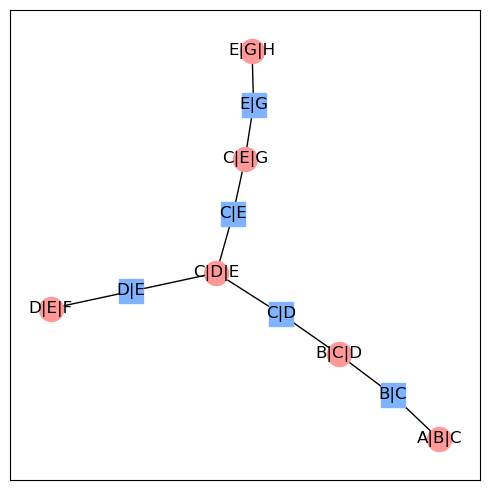

In [21]:
pos = nx.nx_agraph.graphviz_layout(j, prog='neato')
cluster_n = list(filter(lambda n: j.nodes[n]['type'] == 'cluster', j.nodes()))
sepset_n = list(filter(lambda n: j.nodes[n]['type'] == 'sepset', j.nodes()))

fig, ax = plt.subplots(figsize=(5, 5))

nx.draw_networkx_edges(j, pos, ax=ax)
nx.draw_networkx_nodes(j, pos, ax=ax, nodelist=cluster_n, node_color='#ff9999', node_shape='o', alpha=1)
nx.draw_networkx_nodes(j, pos, ax=ax, nodelist=sepset_n, node_color='#80b3ff', node_shape='s', alpha=1)
nx.draw_networkx_labels(j, pos, ax=ax)


fig.tight_layout()